## Importing all required libraries

In [1]:
import pandas as pd 
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

## Loading `takehome_users.csv` dataset

In [2]:
users_df = pd.read_csv("takehome_users.csv", encoding = 'ISO-8859-1')
users_df.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


In [3]:
users_df["last_session_creation_time"] = pd.to_datetime(users_df["last_session_creation_time"], unit='s')
users_df["creation_time"] = pd.to_datetime(users_df["creation_time"])
users_df.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0


## Loading `takehome_user_engagement.csv` dataset

In [5]:
user_engagement_df = pd.read_csv("takehome_user_engagement.csv",encoding = 'ISO-8859-1')
user_engagement_df.head(2)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1


In [6]:
user_engagement_df["time_stamp"] = pd.to_datetime(user_engagement_df["time_stamp"])

## Feature Engineering

I defined a a function as follows to create a new feature called `adopted`.

In [7]:
def is_adopted(dates):
    '''Check if the user has 3 logins within any 7-day window'''
    sorted_dates = sorted(dates) # sorting the dates in ascending order.
    for n_dates in range(len(sorted_dates)-2): # need at least three logins.
        if (sorted_dates[n_dates+2]-sorted_dates[n_dates]).days <=7: # checks if three consequitive logins are within 7 days.
            return True 
    return False   

Initially, the machine learning models constructed using the available features performed poorly. To improve model performance, additional features were engineered based on the existing data. The newly created features include:

>* **logins_within_first_month**: Number of logins within the first month of signup.
>* **logins_within_first_week**: Number of logins within the first week of signup.
>* **month_created**: The month in which the user signed up.
>* **day_created**: The day of the week on which the user signed up.
>* **days_since_signup**: The number of days since the user signed up.

In [8]:
def logins_within_first_month(dates):
    '''Counts number of logins in first 30 days'''
    sorted_dates = pd.to_datetime(sorted(dates))  # Sorting the dates in ascending order.
    first_login = sorted_dates[0]  # First login date
    end_date = first_login + pd.DateOffset(months=1)  # 1 month from the first login
    
    # Counting how many login dates are within the 1 month window
    return (sorted_dates < end_date).sum()

In [9]:
def logins_within_first_week(dates):
    '''Counts number of logins in first 1 week'''
    sorted_dates = pd.to_datetime(sorted(dates))  # Sorting the dates in ascending order.
    first_login = sorted_dates[0]  # First login date
    end_date = first_login + pd.Timedelta(days=7)  # 1 week from the first login
    
    # Counting how many login dates are within the 1 week window
    return (sorted_dates < end_date).sum()

In [10]:
# Apply function to each user
adopted_users = user_engagement_df.groupby('user_id')['time_stamp'].agg(
    adopted=lambda x: is_adopted(x),  # Apply is_adopted function
    logins_within_first_month=lambda x: logins_within_first_month(x), # Apply logins_within_first_month function
    logins_within_first_week=lambda x: logins_within_first_week(x) # Apply logins_within_first_week function
).reset_index()
adopted_users.head(2)

,user_id,adopted,logins_within_first_month,logins_within_first_week
0,1,False,1,1
1,2,True,3,1


In [11]:
combined_df = users_df.merge(adopted_users, left_on='object_id', right_on='user_id', how='left').drop(columns=['user_id'])
combined_df.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,logins_within_first_month,logins_within_first_week
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False,1.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True,3.0,1.0


In [12]:
user_engagement_df["time_stamp"].max()

Timestamp('2014-06-06 14:58:50')

In [13]:
combined_df["month_created"]=combined_df["creation_time"].dt.month
combined_df["day_created"]=combined_df["creation_time"].dt.day_of_week
combined_df["days_since_signup"] = (pd.to_datetime('2014-06-06 14:58:50') - combined_df["creation_time"]).dt.days

In [14]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted                     8823 non-null   object        
 11  logins_within_first_month   8823 non-null   float64   

## Data Wrangling

In [15]:
combined_df["adopted"] = combined_df["adopted"].astype("boolean")

combined_df["invited_by_user_id"] = combined_df["invited_by_user_id"].fillna(0)
combined_df["logins_within_first_month"] = combined_df["logins_within_first_month"].fillna(1)
combined_df["logins_within_first_week"] = combined_df["logins_within_first_week"].fillna(1)
combined_df["last_session_creation_time"] = combined_df["last_session_creation_time"].fillna(combined_df["creation_time"])
combined_df["adopted"] = combined_df["adopted"].fillna(False)

# Feature, Target selection

In [16]:
combined_df.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'adopted',
       'logins_within_first_month', 'logins_within_first_week',
       'month_created', 'day_created', 'days_since_signup'],
      dtype='object')

In [17]:
X = combined_df[['creation_source', 'opted_in_to_mailing_list','enabled_for_marketing_drip',
                 'org_id', 'invited_by_user_id','logins_within_first_month','logins_within_first_week',
                 'day_created','month_created','days_since_signup']]
y = combined_df['adopted']

In [18]:
X = pd.get_dummies(X, columns=['creation_source'], drop_first=True)
X.head(2)

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,logins_within_first_month,logins_within_first_week,day_created,month_created,days_since_signup,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,10803.0,1.0,1.0,1,4,45,False,False,False,False
1,0,0,1,316.0,3.0,1.0,4,11,203,True,False,False,False


## Oversampling to address imbalanced data

In [19]:
y.value_counts()

adopted
False    10344
True      1656
Name: count, dtype: Int64

In [21]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

oversampler = RandomOverSampler(random_state=123)
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

## Modeling

### 1. Logistic Regression (LogisticRegression)

In [22]:
# Train the model with resampled data
logreg_model = LogisticRegression(C = 0.1, penalty='l1', random_state=123, solver='liblinear')
logreg_model.fit(X_resampled, y_resampled)

# Make predictions
y_pred_logreg = logreg_model.predict(X_test)

# Evaluate metrics
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
f1_score_logreg = f1_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)

# Print results
print(f'Logistic Regression Accuracy: {accuracy_logreg:.4f}')
print(f'Logistic Regression F1 Score: {f1_score_logreg:.4f}')
print(f'Logistic Regression Precision: {precision_logreg:.4f}')
print(f'Logistic Regression Recall: {recall_logreg:.4f}')


Logistic Regression Accuracy: 0.9208
Logistic Regression F1 Score: 0.7473
Logistic Regression Precision: 0.6675
Logistic Regression Recall: 0.8489


### 2. Gradient Boosting (GradientBoostingClassifier)

In [23]:
# Train the model with resampled data
gb_model = GradientBoostingClassifier(random_state=123, learning_rate = 0.1, n_estimators= 50, subsample= 0.8)
gb_model.fit(X_resampled, y_resampled)

# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Evaluate metrics
accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_score_gb = f1_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)

# Print results
print(f'Gradient Boosting Accuracy: {accuracy_gb:.4f}')
print(f'Gradient Boosting F1 Score: {f1_score_gb:.4f}')
print(f'Gradient Boosting Precision: {precision_gb:.4f}')
print(f'Gradient Boosting Recall: {recall_gb:.4f}')


Gradient Boosting Accuracy: 0.9258
Gradient Boosting F1 Score: 0.7608
Gradient Boosting Precision: 0.6852
Gradient Boosting Recall: 0.8550


### 3. Random Forest (RandomForestClassifier)

In [24]:
# Train the model with resampled data
rf_model = RandomForestClassifier(max_depth = 10, n_estimators = 200, random_state=123)
rf_model.fit(X_resampled, y_resampled)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_score_rf = f1_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

# Print results
print(f'Random Forest Accuracy: {accuracy_rf:.4f}')
print(f'Random Forest F1 Score: {f1_score_rf:.4f}')
print(f'Random Forest Precision: {precision_rf:.4f}')
print(f'Random Forest Recall: {recall_rf:.4f}')


Random Forest Accuracy: 0.9279
Random Forest F1 Score: 0.7659
Random Forest Precision: 0.6936
Random Forest Recall: 0.8550


## Confusion Matrix

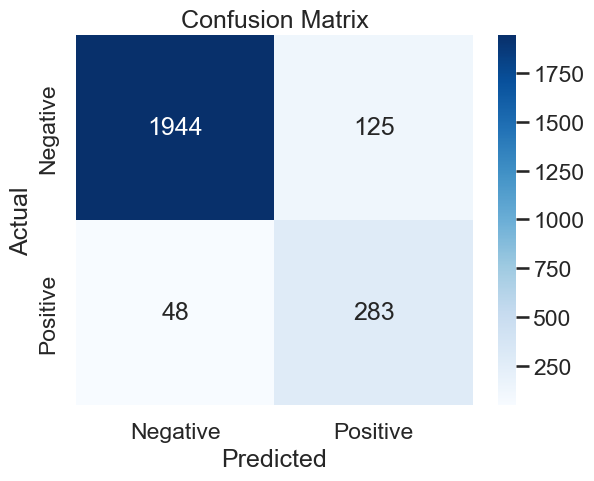

In [25]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.set_theme("talk")
# Plotting confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Feature Importance

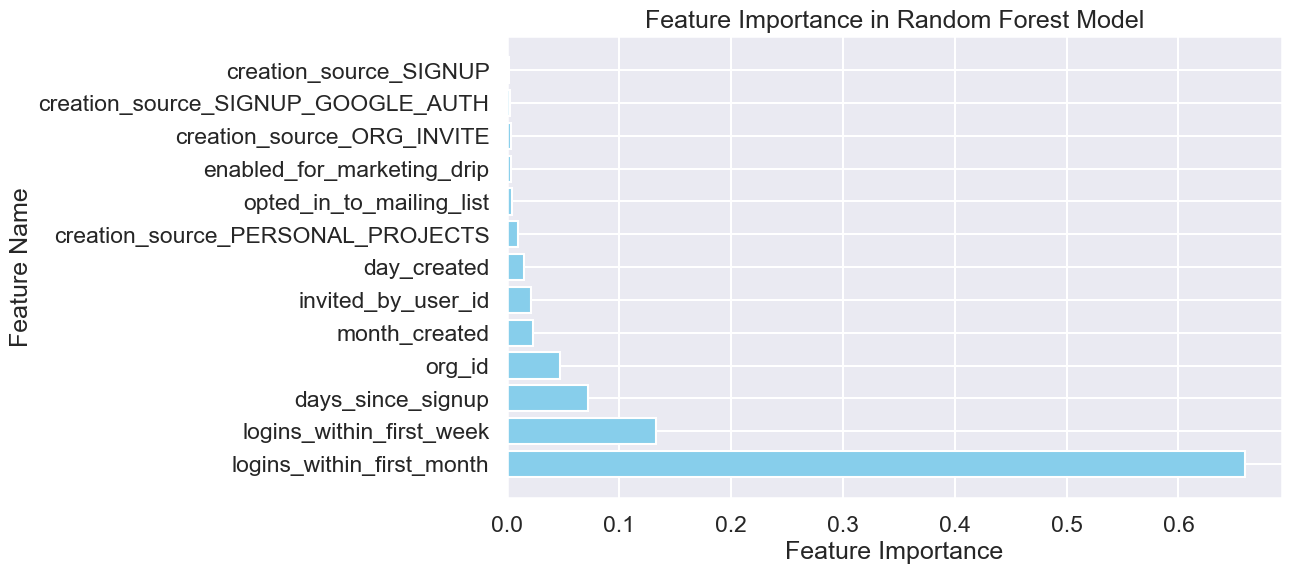

In [26]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to visualize feature importances

feature_names = X.columns  # assuming X_train contains the feature names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance in Random Forest Model')
plt.show()

## Feature Imapact on Target

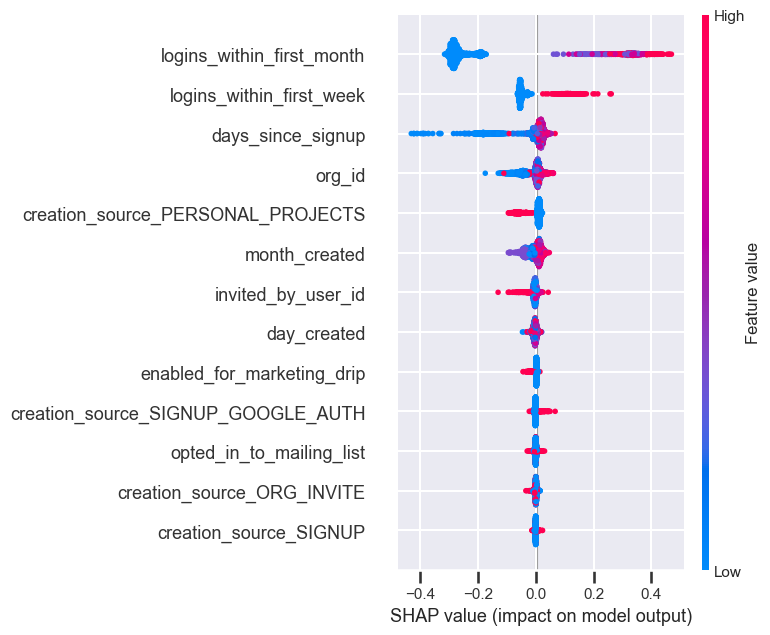

In [44]:
# Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Get SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot for all classes (if it's classification)
shap.summary_plot(shap_values[:, :, 1], X_test)
